# 4square_channel

## 5. 4square_channel.png Four square = imagery, surface, bed&surface, change

### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string
import matplotlib.gridspec as gridspec
import pickle

In [ ]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

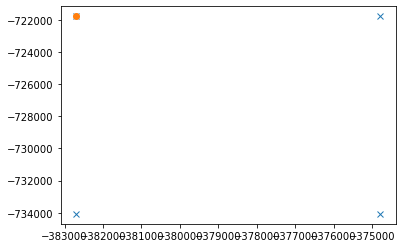

In [ ]:
plt.plot([xmin,xmin,xmax,xmax],[ymin,ymax,ymin,ymax],'x')
plt.plot(xmin,ymax,'o')

In [ ]:
print(xmin,ymax)


-382700 -721770.2


In [12]:
# #load REMA dem ORIGINAL
# with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
#     extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     im_REMA = image.read(1)
    
# x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
# y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

# x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
# x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
# y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
# y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

# x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
# y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

# xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

# im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
# im_REMA_d[im_REMA_d==-99.99] = np.nan
# im_REMA_c = im_REMA_d

In [10]:
import wget

In [ ]:
url = 'ftp://ftp.geo.vuw.ac.nz/pub/outgoing/horganhu/kis2_remaDebiasMean.csv'
outfile = '/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/kis2_remaDebiasMean.csv'
wget.download(url,out=outfile)

'/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/kis2_remaDebiasMean.csv'

In [6]:
im_REMA[im_REMA!=-9999.0].mean()

67.36358

In [7]:
# Load modis moa
# with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic_siplecoast.tif') as image:
#     extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     im_moa = image.read(1)
#     window=Window(0, 0, 10000, 10000)
#crop the moa image to channel area
#gdal_translate -projwin -382700.0 -721770.2 -374781.9 -734075.1 -of GTiff /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa125_2009_hp1_v1.1.tif /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_channel.tif
# with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_channel.tif') as image:
with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_KIS2.tif') as image:
    extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_moa = image.read(1)

In [8]:
extent_moa

[-392700.0, -364825.0, -743925.0, -711675.0]

In [9]:
#load REMA diff
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im_REMAdiff = image.read(1)
    im_REMAdiff[im_REMAdiff==-9999] = np.nan
    im_REMAdiff = im_REMAdiff / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]

In [10]:
im_REMAdiff[~np.isnan(im_REMAdiff)].max()

2602.6602

In [11]:
im_REMAdiff[~np.isnan(im_REMAdiff)].min()

-2633.8071

In [12]:
# im_REMAdiff[np.abs(im_REMAdiff)>50]=np.nan

In [13]:
# # Load ice base interpolated from radar results
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'_ice_base.npy')
# ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickn.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [14]:
gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
gpr = gpr[gpr.camp=='KIS2'].copy()
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0','line8']
for line_name in gpr.line_name.unique():
    if line_name not in cross_channel_lines:
        i_names = gpr[gpr.line_name == line_name].index
        gpr.drop(i_names,inplace=True)

In [15]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

In [16]:
# # get icesat2 diff lines
# import sys
# sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')
# from cross_channel import icesat_dataset
# ds = icesat_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/ds_subset_kamb_20201111.nc")
# ds.getdata_dhdt(cycle_number_from=3,cycle_number_till=8)
# ds.dadh.query(f'x>{xmin} & x<{xmax} & y<{ymax} & y>{ymin}',inplace=True)

In [17]:
bbox = box(xmin, xmax, ymin, ymax )
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [18]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [19]:
np.amax(im_moa)

16920

In [20]:
np.amin(im_moa)

15312

In [21]:
xmin, xmax, ymin, ymax = -382700/1000, -374781.9/1000, -734075.1/1000, -721770.2/1000

In [22]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [25]:
mask=gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/mask_for_remadiff.shp')

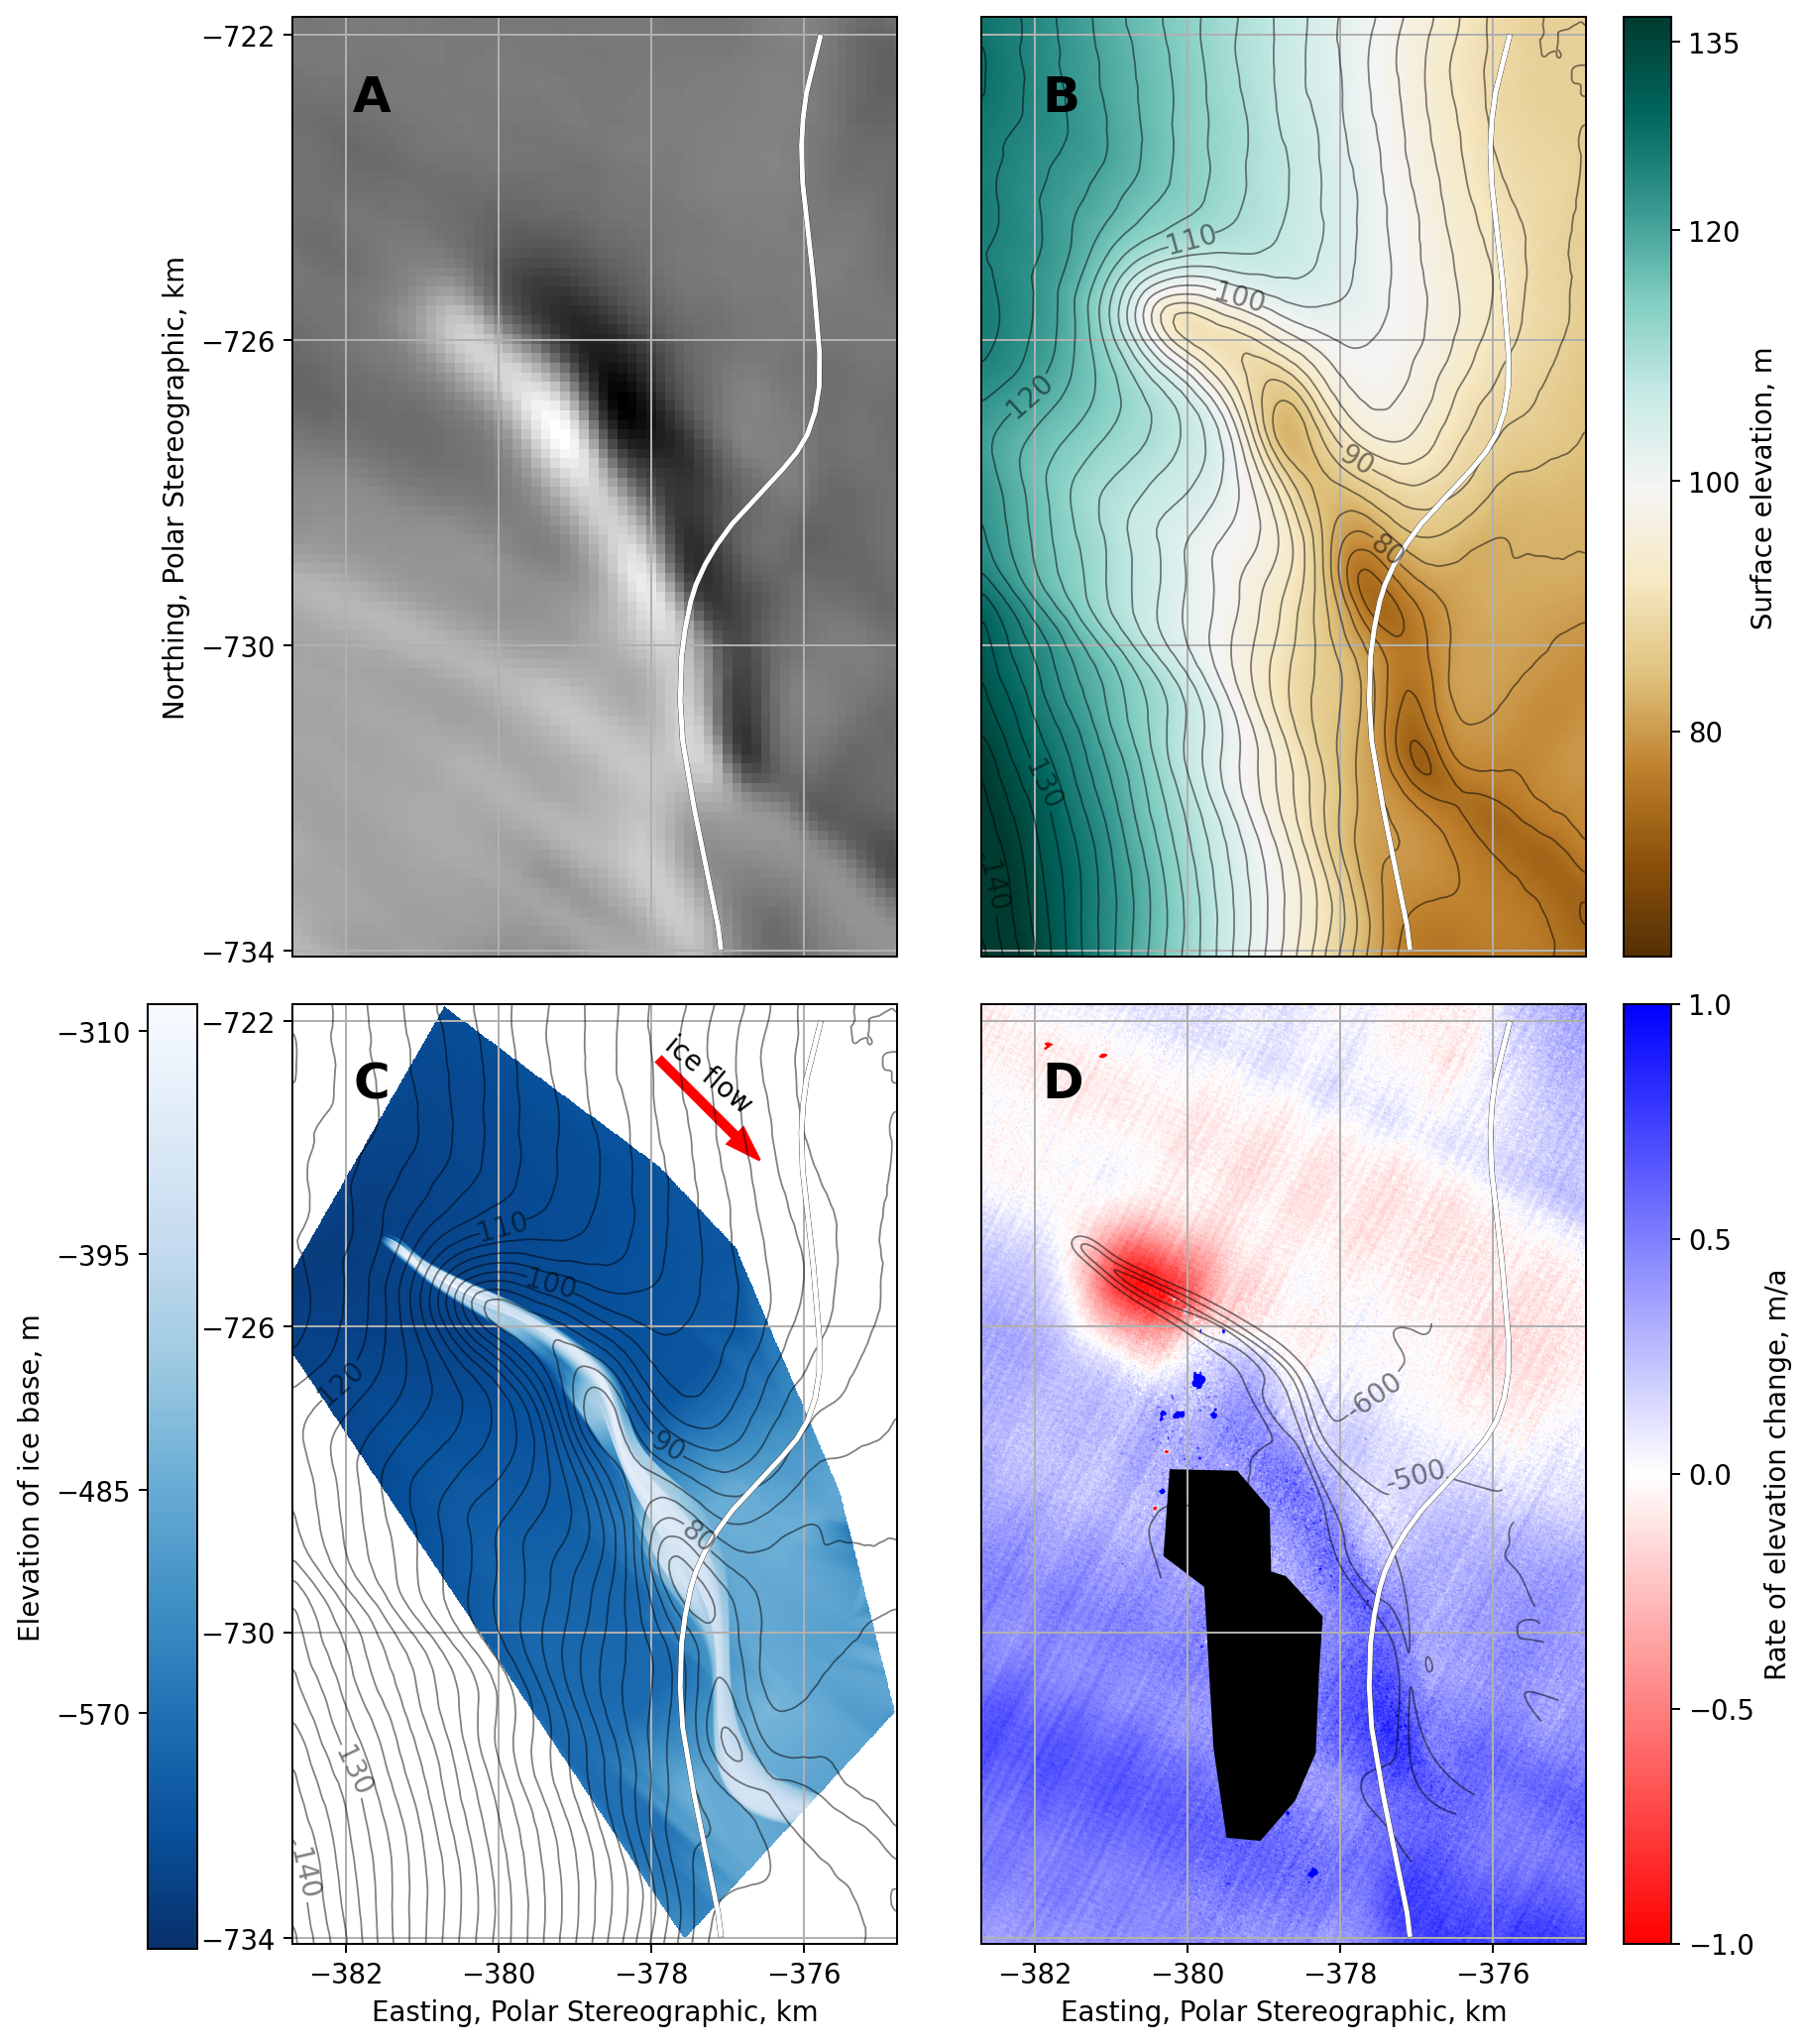

In [28]:
fig, ax = plt.subplots(2,2, dpi=180,figsize=(11,14.3),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05, 
                   # right=0.95, left=0.05
                   )

plt.rcParams.update({'font.size': 11})

samp = 50


#A imagery
aa = ax[0,0].imshow(im_moa,extent=np.array(extent_moa)/1000, cmap='gist_gray')
ax[0,0].plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=2.2)
ax[0,0].plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=2)
ax[0,0].grid()
ax[0,0].set_xlim([xmin,xmax])
ax[0,0].set_ylim([ymin,ymax])
ax[0,0].set_ylabel('Northing, Polar Stereographic, km')
ax[0,0].tick_params(bottom=False, labelbottom=False,
#                     labelrotation=45
                   )
ax[0,0].set_yticks(yticks)
ax[0,0].set_xticks(xticks)


# # cbb = fig.colorbar(aa,ax=ax[0,0])
# # # ax[0,0].text(-0.1, 1.1, 'A', transform=ax[0,0].transAxes, 
# # #             size=20, weight='bold')
# # #

# #=================================================================================================

# #B surface
ax[0,1].plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=2.2)
ax[0,1].plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=2)

a1 = ax[0,1].imshow(im_REMA+geoid_correction,extent=np.array(extent_REMA)/1000,vmin=15+geoid_correction,vmax=90+geoid_correction, cmap='BrBG')

CS1 =  ax[0,1].contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction ,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)

ax[0,1].clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i')
ax[0,1].grid()
ax[0,1].set_xlim([xmin,xmax])
ax[0,1].set_ylim([ymin,ymax])
ax[0,1].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

ax[0,1].set_yticks(yticks)
ax[0,1].set_xticks(xticks)
cb1 = fig.colorbar(a1,ax=ax[0,1])
cb1.set_label('Surface elevation, m')
cb1.set_ticks(np.round(np.linspace(15+geoid_correction ,90+geoid_correction ,5)/5)*5)



# #=================================================================================================

# #C base with surface contours
ax[1,0].plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=2.2)
ax[1,0].plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=2)
ax[1,0].plot(gpr.x,gpr.y,'k.',label='radar profiles',markersize=0.025)



CS2 =  ax[1,0].contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction ,vmax=90+geoid_correction , 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)
plt.clabel(CS2,CS2.levels[0::4], inline=1,  fmt='%i')


im3 = ax[1,0].imshow(ice_base+geoid_correction + res_correction,extent=np.array(extent_l2l)/1000,cmap='Blues_r',vmin=-700+geoid_correction + res_correction,vmax=-340+geoid_correction + res_correction)


ax[1,0].grid()
ax[1,0].set_xlim([xmin,xmax])
ax[1,0].set_ylim([ymin,ymax])
ax[1,0].set_xticks(xticks)

cbaxes = fig.add_axes([0.09, 0.123, 0.025, 0.37]) # location of colorbar left bottom width height
# ax1 = fig.add_axes([-0.1, 0, -0.1, 1])
cb3 = plt.colorbar(im3,ax=ax[1,0],cax=cbaxes)
cb3.set_label('Elevation of ice base, m')
cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)
cb3.ax.yaxis.set_ticks_position("left")
cb3.ax.yaxis.set_label_position("left")

ax[1,0].arrow(-377.9, -722.5,1,-1,width=0.1,color='r')
ax[1,0].annotate('ice flow',xy=(-377.9, -722.5-0.7), rotation=-40)
# ax[1,0].annotate( 'Ice flow direction',(-377.9+1.5, -722.5-0.8),xytext=(-377.9, -722.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# ax[1,0].annotate( 'Ice flow direction',(-377.9+3, -722.5-3),xytext=(-377.9, -722.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# ax[1,0].annotate( 'Ice flow direction',(-377.9+8, -722.5-8),xytext=(-377.9, -722.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# ax[1,0].annotate( 'Ice flow direction',(-377.9+1, -722.5-1),xytext=(-377.9, -722.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# ax[1,0].annotate( 'Ice flow direction',(-377.9+5, -722.5-5),xytext=(-377.9, -722.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
ax[1,0].set_xlabel('Easting, Polar Stereographic, km')
# ax[1,0].set_ylabel('y, Polar Stereographic, km')
ax[1,0].set_yticks(yticks)


# #=================================================================================================

# #D rate of change of surf
ax[1,1].plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=2.2)
ax[1,1].plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=2)
CS4 =  ax[1,1].contour(xv[:,500:]/1000,yv[:,500:]/1000,ice_base_smooth[:,500:]+geoid_correction + res_correction,
                       [-600,-500,-400],
                       linestyles='solid',
                      colors='black',
                  alpha=0.5,linewidths=0.7)
# ax[1,1].clabel(CS4,[CS4.levels[1],CS4.levels[-1]], inline=1,  fmt='%i')
clabel_locations = [(-377.5, -727), (-376-1, -727-1)]
ax[1,1].clabel(CS4, manual=clabel_locations, inline=1,  fmt='%i')
ax[1,1].tick_params(left=False, labelleft=False)

im4 = ax[1,1].imshow(-im_REMAdiff,extent=np.array(extent_REMAdiff)/1000, vmin=-1,vmax=1,cmap='bwr_r')
# ax[1,1].plot(-379.8,-728.1,'kX')
# ax[1,1].plot(-379,-732,'kX')
# ax[1,1].plot(-381.6,-732.5,'kX')
# ax[1,1].plot(-375.5,-725,'kX')

# ax[1,1].scatter(ds.dadh.x,ds.dadh.y,c=ds.dadh.dhdt,cmap='bwr_r',vmin=-0.8, vmax=1)
ax[1,1].grid()
ax[1,1].set_xlim([xmin,xmax])
ax[1,1].set_ylim([ymin,ymax])
ax[1,1].set_yticks(yticks)
ax[1,1].set_xticks(xticks)

cb4 = fig.colorbar(im4,ax=ax[1,1])
cb4.set_label('Rate of elevation change, m/a')
cb4.set_ticks(np.linspace(-1,1,5))

x, y = mask.iloc[0,1].exterior.xy
ax[1,1].fill(np.array(x)/1000, np.array(y)/1000, alpha=1, fc='k', ec='none')

ax[1,1].set_xlabel('Easting, Polar Stereographic, km')


#write A B C D from a loop
axs = ax.flat
for n, a in enumerate(axs):
    a.text(0.1, 0.9, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')
    
plt.subplots_adjust(wspace=0.01, hspace=0.05,
                   # right=0.95, left=0.05
                   )
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/4square_channel.png')

##############################

plt.show()
#

In [115]:
np.array(mask.iloc[0,1].exterior.xy[0])

array([-380235.69453794, -379349.05621826, -378925.88792933,
       -378905.73705843, -378714.30378486, -378230.68288322,
       -378281.06006048, -378321.36180228, -378593.39855945,
       -379046.79315474, -379490.11231458, -379661.39471724,
       -379782.29994265, -380316.29802154, -380235.69453794])

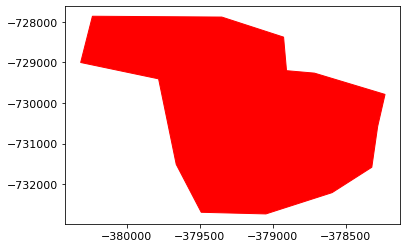

In [104]:
x, y = mask.iloc[0,1].exterior.xy
plt.fill(x, y, c="red")

In [99]:
mask.iloc[0,1].exterior.xy

(array('d', [-380235.69453793566, -379349.0562182635, -378925.8879293291, -378905.7370584275, -378714.30378486187, -378230.68288322253, -378281.06006047665, -378321.36180227995, -378593.39855945203, -379046.79315473896, -379490.112314575, -379661.39471723896, -379782.2999426488, -380316.2980215422, -380235.69453793566]),
 array('d', [-727865.9230088284, -727886.0738797301, -728379.7702168203, -729205.9559237874, -729266.4085364924, -729790.331179935, -730576.215145099, -731583.758690181, -732208.4356881317, -732732.3583315744, -732692.0565897711, -731513.2306420251, -729407.4646328039, -729004.4472147711, -727865.9230088284]))

In [86]:
!ls /Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/

indicies_which_intersect.txt


In [66]:
350/75

4.666666666666667

In [70]:
np.arange(-650,-250,100)

array([-650, -550, -450, -350])

In [79]:
np.arange(-600,-350,50)

array([-600, -550, -500, -450, -400])

In [23]:
# https://stackoverflow.com/questions/51446526/plt-subplot-adjust-not-working-correctly

# contour only

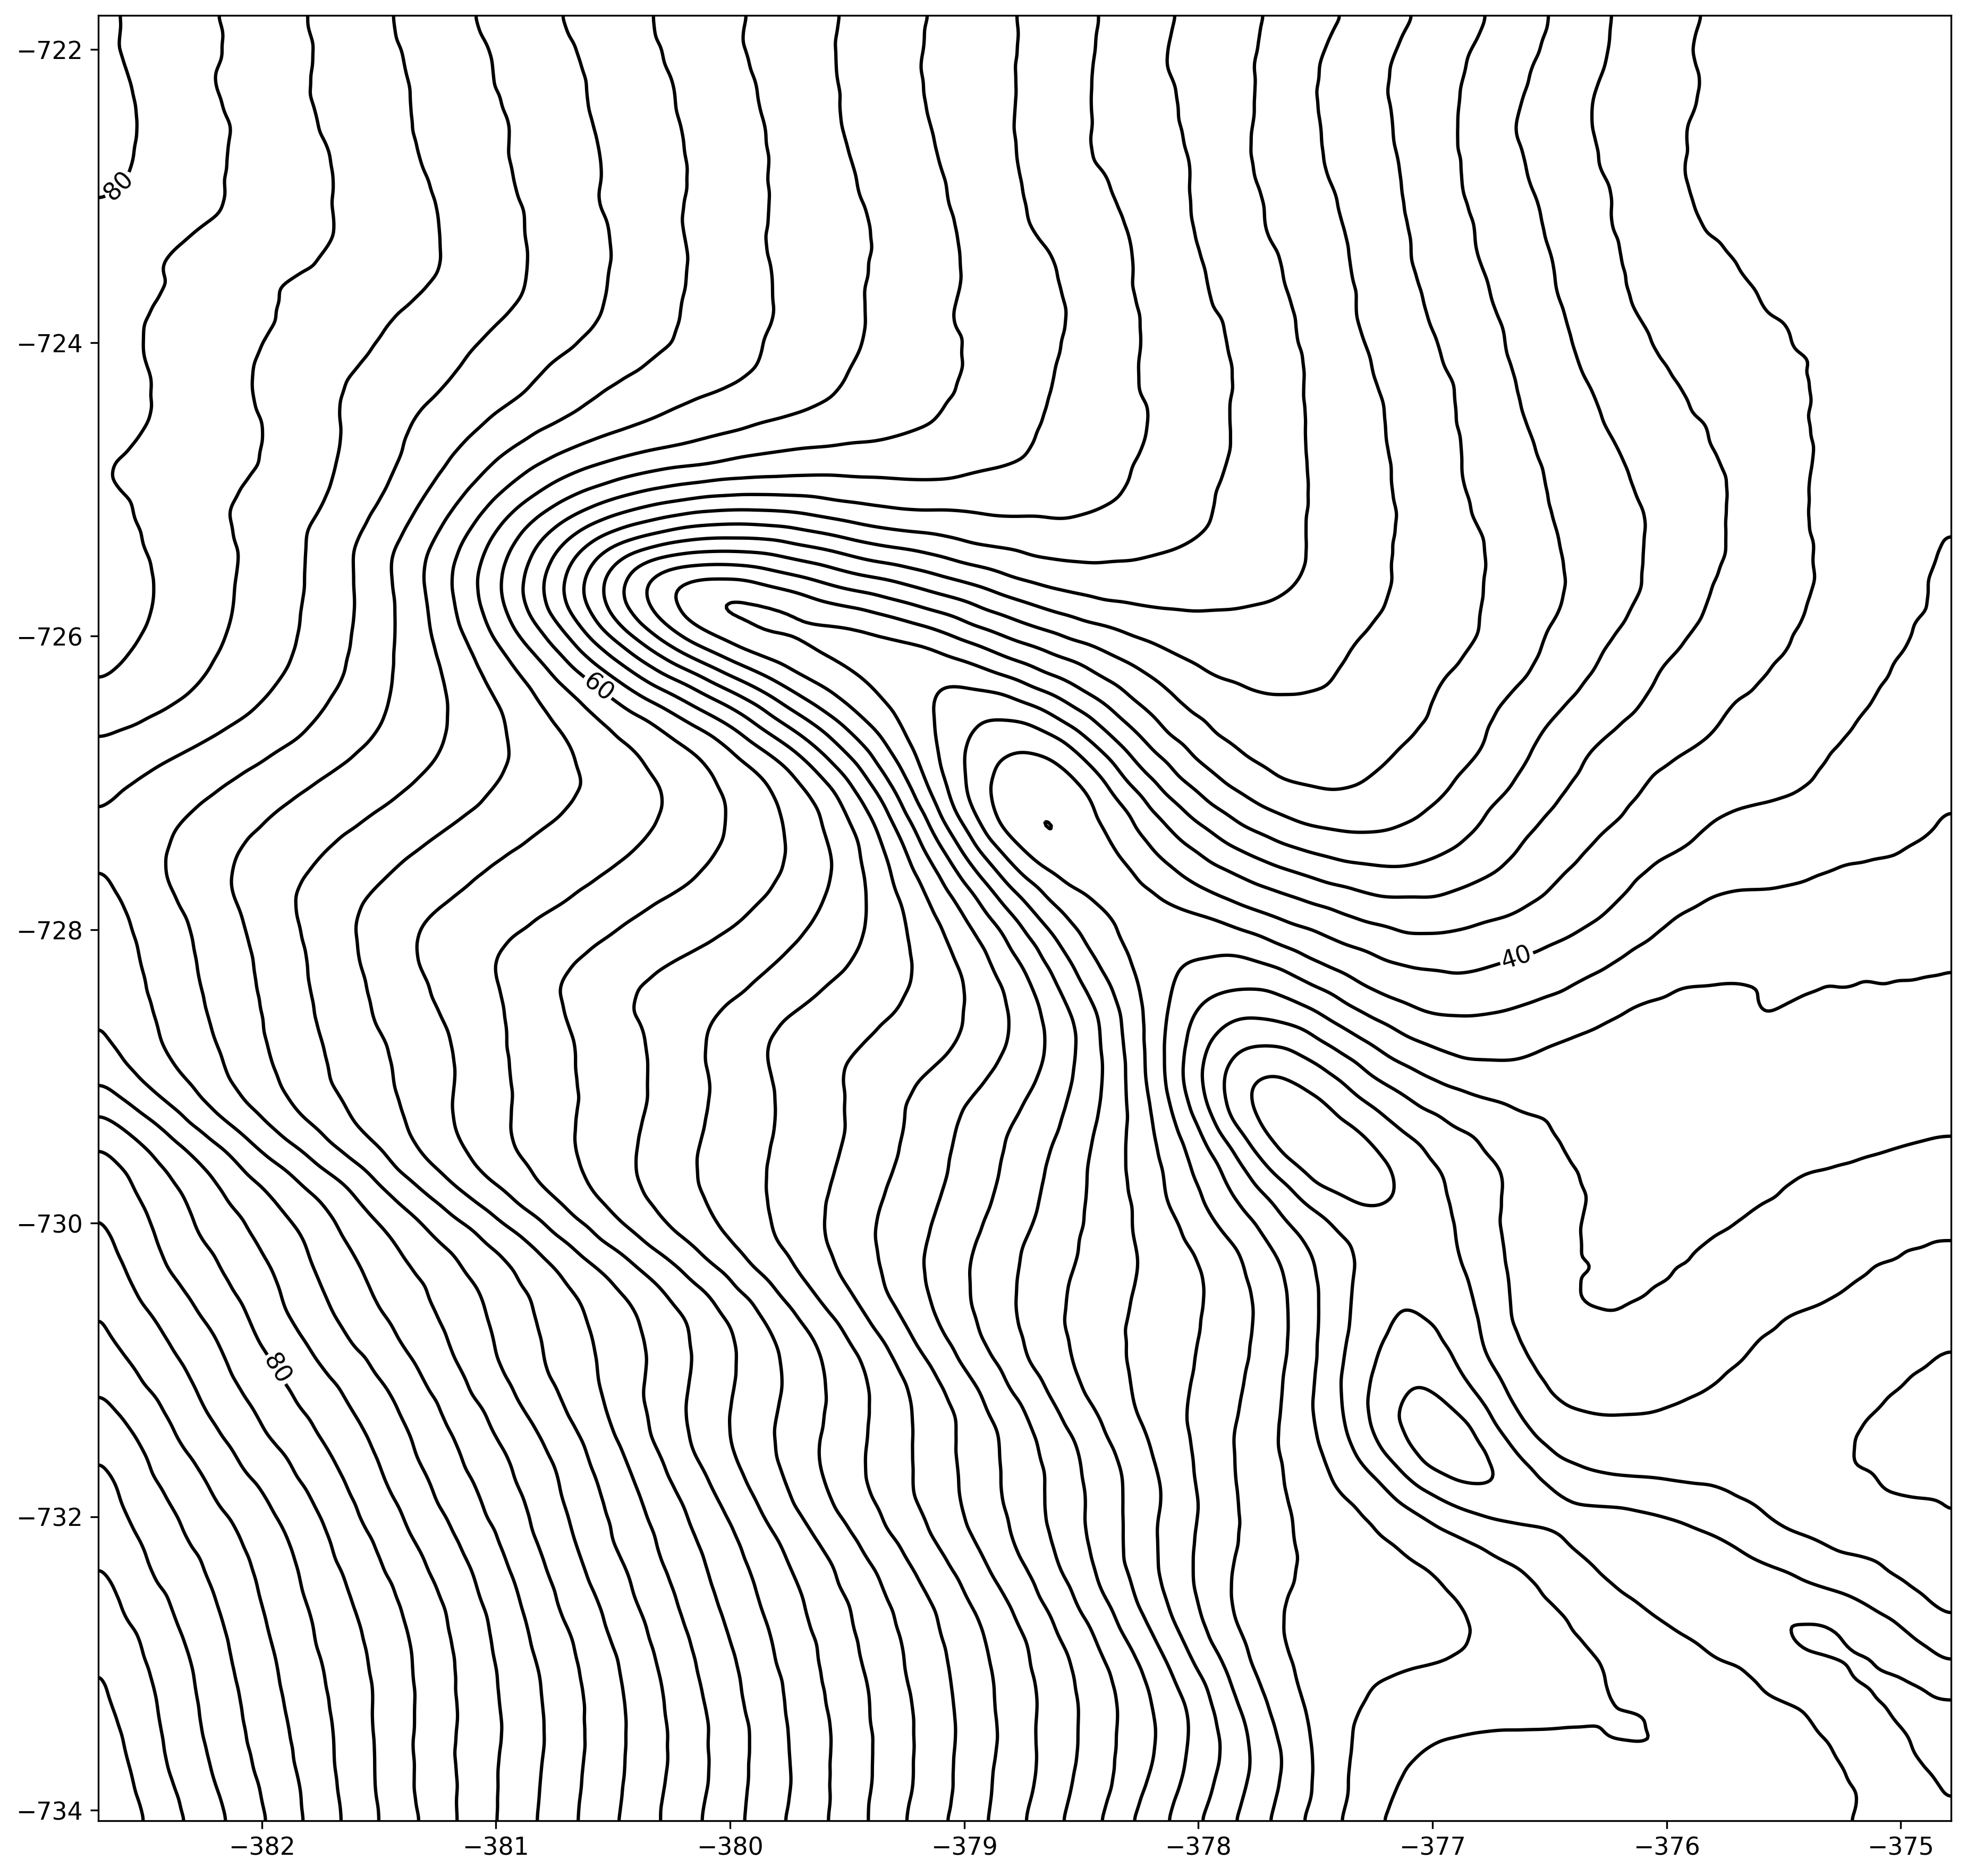

In [35]:
plt.figure(figsize=(15,15),dpi=300)
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

samp = 10

CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp],
                      np.arange(20,100)[::2], alpha=1,
                  colors='black'
                 )

plt.clabel(CS,CS.levels[0::10], inline=1,  fmt='%i')
# plt.imshow(im_REMA,extent=extent_REMA,vmin=15,vmax=90, cmap='BrBG')
# plt.grid()
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])
# plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)



# cb1 = fig.colorbar(a1,ax=plt)
# cb1.label('elevation,')
# cb1.ticks(np.round(np.linspace(15,90,5)/5)*5)



plt.show()

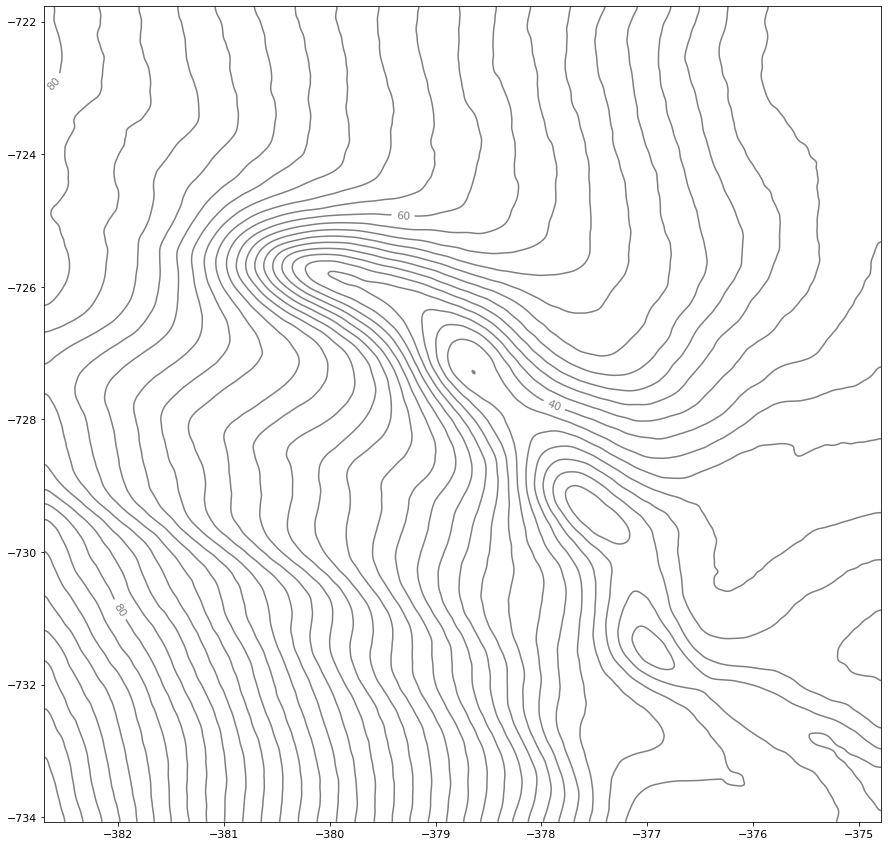

In [160]:
plt.figure(figsize=(15,15))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

samp = 10

CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp],
                      np.arange(20,100)[::2], alpha=0.5,colors='black')

plt.clabel(CS,CS.levels[0::10], inline=1,  fmt='%i')
# plt.imshow(im_REMA,extent=extent_REMA,vmin=15,vmax=90, cmap='BrBG')
# plt.grid()
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])
# plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)



# cb1 = fig.colorbar(a1,ax=plt)
# cb1.label('elevation,')
# cb1.ticks(np.round(np.linspace(15,90,5)/5)*5)



plt.show()

# histogram of melt

AttributeError: 'AxesSubplot' object has no attribute 'flat'

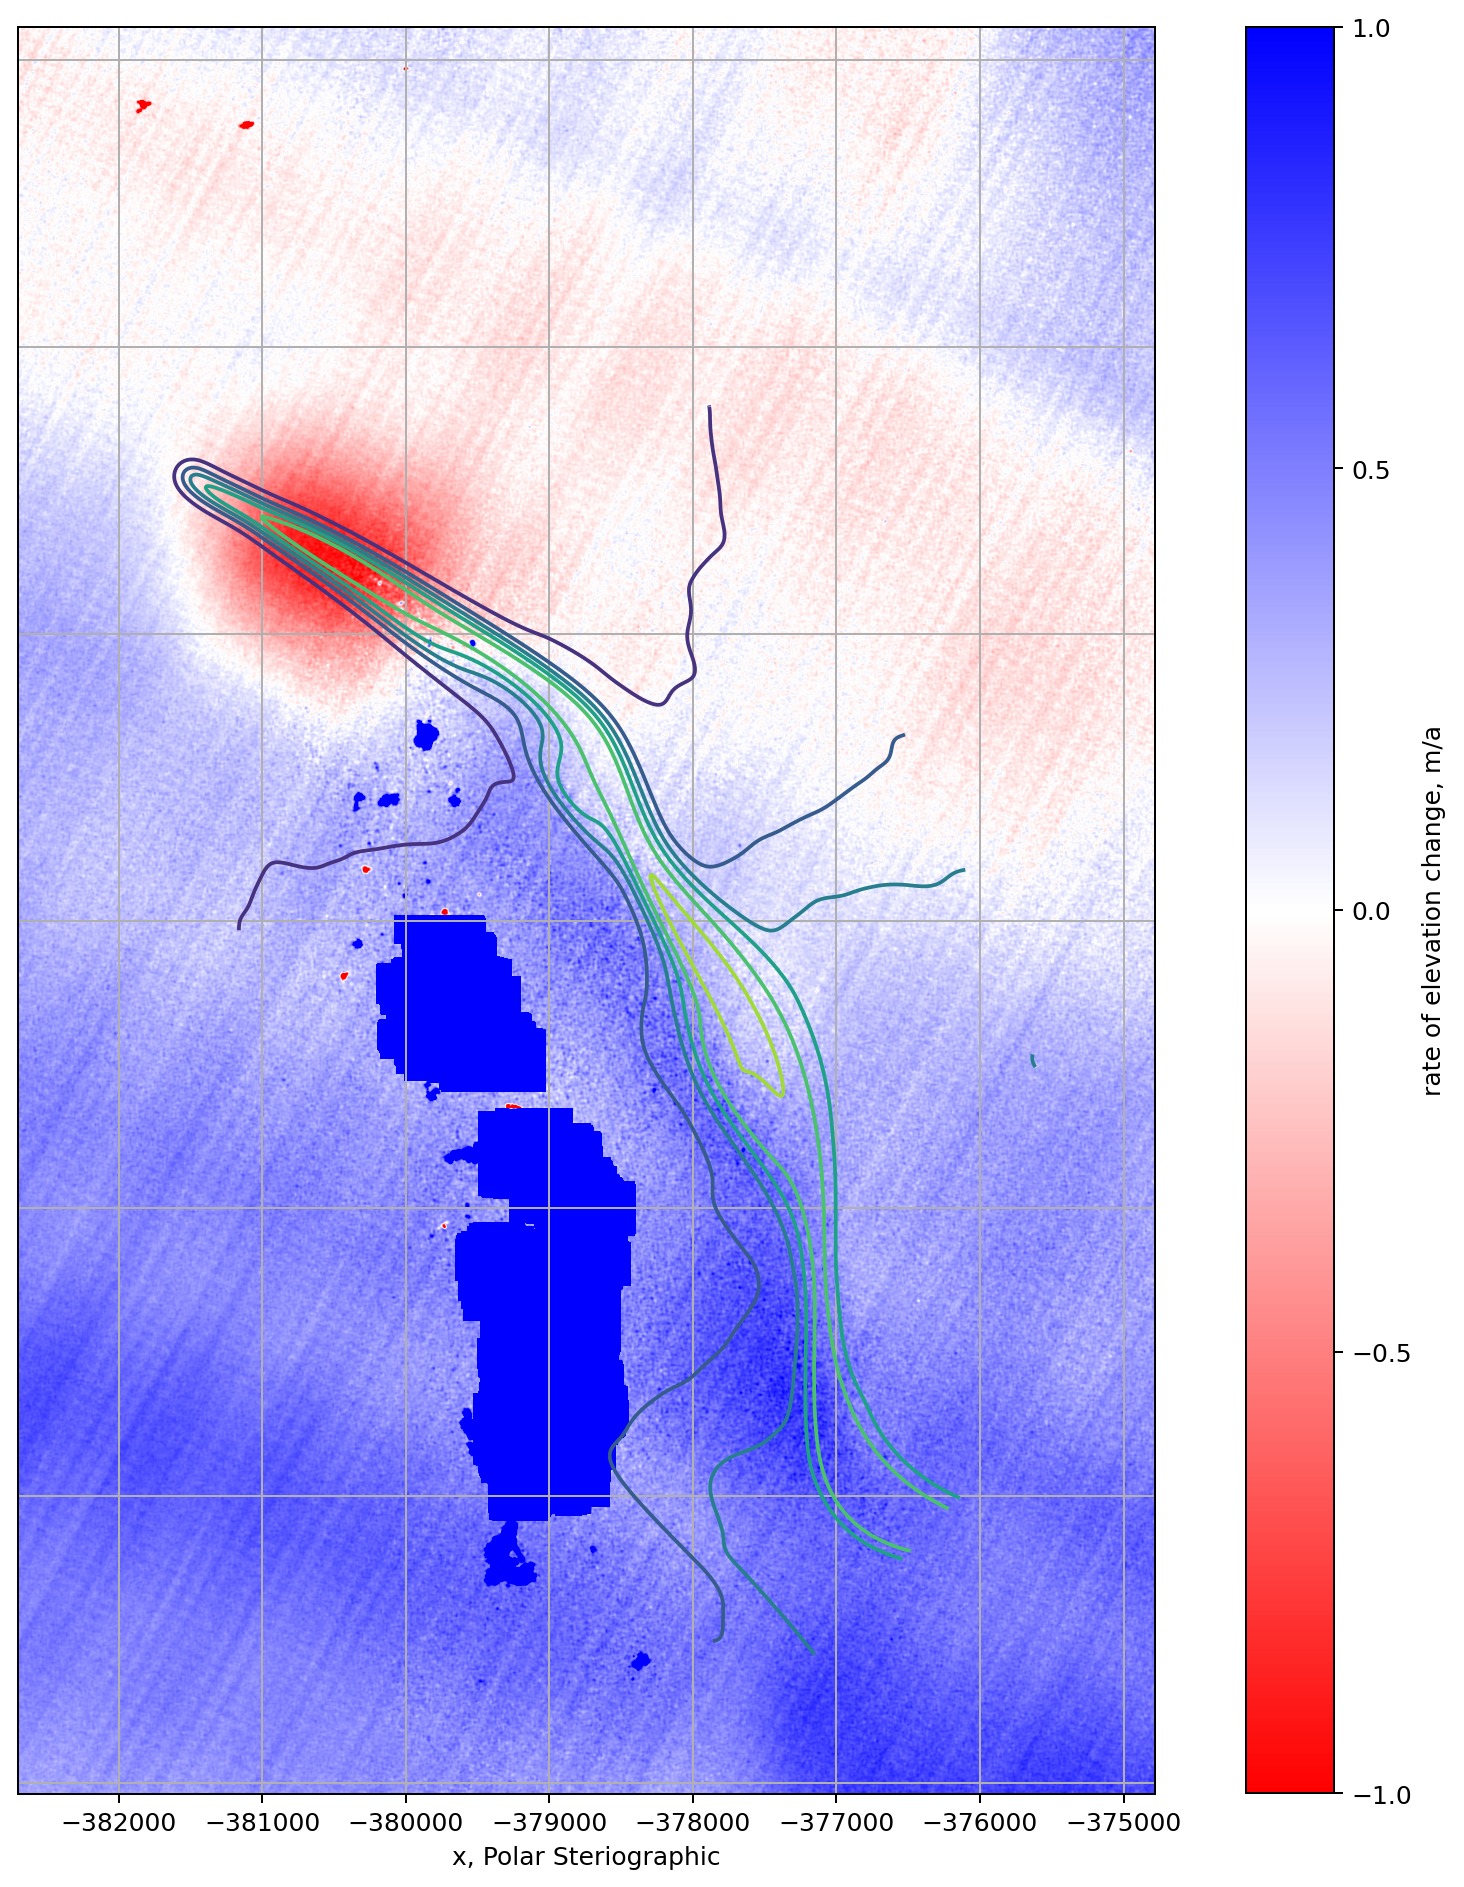

In [14]:
fig, ax = plt.subplots(1,1, dpi=180,figsize=(13,13))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

# #

# #D rate of change of surf
CS4 =  ax.contour(xv[:,500:],yv[:,500:],ice_base_smooth[:,500:],np.arange(-700,-300,50))
# ax.clabel(CS4, inline=1, fontsize=8, fmt='%i')
ax.tick_params(left=False, labelleft=False)

im4 = ax.imshow(-im_REMAdiff,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap='bwr_r')
# ax.scatter(ds.dadh.x,ds.dadh.y,c=ds.dadh.dhdt,cmap='bwr_r',vmin=-0.8, vmax=1)
ax.grid()
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])


cb4 = fig.colorbar(im4,ax=ax)
cb4.set_label('rate of elevation change, m/a')
cb4.set_ticks(np.linspace(-1,1,5))
ax.set_xlabel('x, Polar Steriographic')


#write A B C D from a loop
axs = ax.flat
for n, a in enumerate(axs):
    a.text(-0.1, 1.05, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/4square_channel.png')

##############################

plt.show()
#